# Plot correlation between boundary and mC/ATAC/RNA

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, zscore
import anndata
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import cm as cm
import seaborn as sns
from matplotlib.colors import LogNorm

mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'


In [2]:
leg = ['L23_IT', 'L4_IT', 'L5_IT', 'L6_IT', 'L6_IT_Car3', 'L56_NP', 'L6_CT', 'L6b', 'L5_ET', 'Amy', 
       'Lamp5', 'Lamp5_LHX6', 'Sncg', 'Vip', 'Pvalb', 'Pvalb_ChC', 'Sst', 'CHD7', 
       'MSN_D1', 'MSN_D2', 'Foxp2', 'SubCtx', 
       'ASC', 'ODC', 'OPC', 'MGC', 'PC', 'EC', 'VLMC'
      ]
legname = ['L2/3-IT', 'L4-IT', 'L5-IT', 'L6-IT', 'L6-IT-Car3', 'L5/6-NP', 'L6-CT', 'L6b', 'L5-ET', 'Amy-Exc', 
       'Lamp5', 'Lamp5-Lhx6', 'Sncg', 'Vip', 'Pvalb', 'Pvalb-ChC', 'Sst', 'Chd7', 
       'MSN-D1', 'MSN-D2', 'Foxp2', 'SubCtx-Cplx', 
       'ASC', 'ODC', 'OPC', 'MGC', 'PC', 'EC', 'VLMC'
      ]
leg2name = {xx:yy for xx,yy in zip(leg, legname)}


In [3]:
leg = {'exc': ['L23_IT', 'L4_IT', 'L5_IT', 'L6_IT', 'L6_IT_Car3', 'L56_NP', 'L6_CT', 'L6b', 'Amy'], 
       'inh': ['Lamp5', 'Lamp5_LHX6', 'Sncg', 'Vip', 'Pvalb', 'Pvalb_ChC', 'Sst', 'CHD7'], 
       'msn': ['MSN_D1', 'MSN_D2', 'Foxp2'], 
       'sub': ['SubCtx'], 
       'glia': ['ASC', 'ODC', 'OPC'], 
       'mgc': ['MGC'], 
       'smc': ['PC'], 
       'endo': ['EC'], 
       'fibro': ['VLMC'],
      }
leg['neu'] = leg['exc'] + leg['inh'] + leg['msn'] + leg['sub']
leg['all'] = leg['neu'] + leg['glia'] + leg['mgc'] + leg['smc'] + leg['endo'] + leg['fibro']


In [4]:
group_name = 'neu'

In [5]:
leg = pd.Index(leg[group_name])
legname = leg.map(leg2name)
res = 25000

In [6]:
indir = '/data/hba/domain_majortype/'
outdir = f'/home/jzhou_salk_edu/sky_workdir/hba/domain_majortype/diff/{group_name}/'
outdir = './'

In [7]:
boundcg = pd.read_hdf(f'{outdir}bound_mCG.hdf', key='data')
boundch = pd.read_hdf(f'{outdir}bound_mCH.hdf', key='data')
boundatac = pd.read_hdf(f'{outdir}bound_ATAC.hdf', key='data')

In [8]:
legatac = boundatac.columns

In [9]:
bound_count_ct = pd.read_hdf(f'{indir}MajorType_boundcount.hdf', key='data').loc[leg]
cell_count_ct = pd.read_csv(f'{indir}MajorType_cellcount.csv.gz', index_col=0, header=0, squeeze=True).loc[leg]
bound_prob_ct = (bound_count_ct / cell_count_ct[:,None]).T


In [10]:
binall = pd.read_hdf('bin_stats.hdf', key='data')


In [11]:
selb = (binall['chi2filter'] & binall['diff_sc'] & binall['bklfilter'] & binall['ins_lm'] & (binall['probdiff']>0.05))
print(sum(selb))

1720


In [12]:
tmpcg = boundcg.astype(float).loc[selb].values
tmpcg = zscore(tmpcg, axis=1)


In [13]:
tmpch = boundch.astype(float).loc[selb].values
tmpch = zscore(tmpch, axis=1)


In [14]:
tmpatac = boundatac.astype(float).loc[selb].values
tmpatac = zscore(tmpatac, axis=1)


In [15]:
tmp3c = bound_prob_ct.loc[selb].values
tmp3c = zscore(tmp3c, axis=1)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


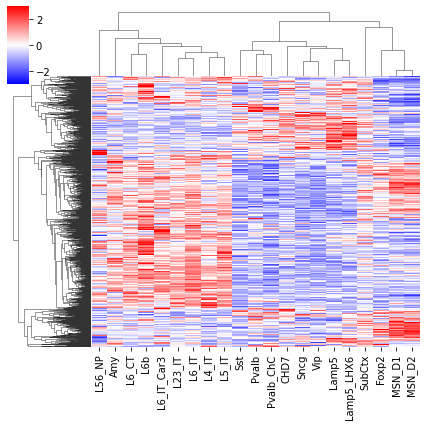

In [16]:
cg = sns.clustermap(tmp3c, cmap='bwr', vmin=-3, vmax=3, metric='cosine', xticklabels=leg, yticklabels=[], figsize=(6,6))


In [17]:
rorder = cg.dendrogram_row.reordered_ind.copy()
corder = cg.dendrogram_col.reordered_ind.copy()

In [18]:
idxatac = np.arange(len(leg))[leg.isin(legatac)]
corderatac = [xx for xx in corder if xx in idxatac]

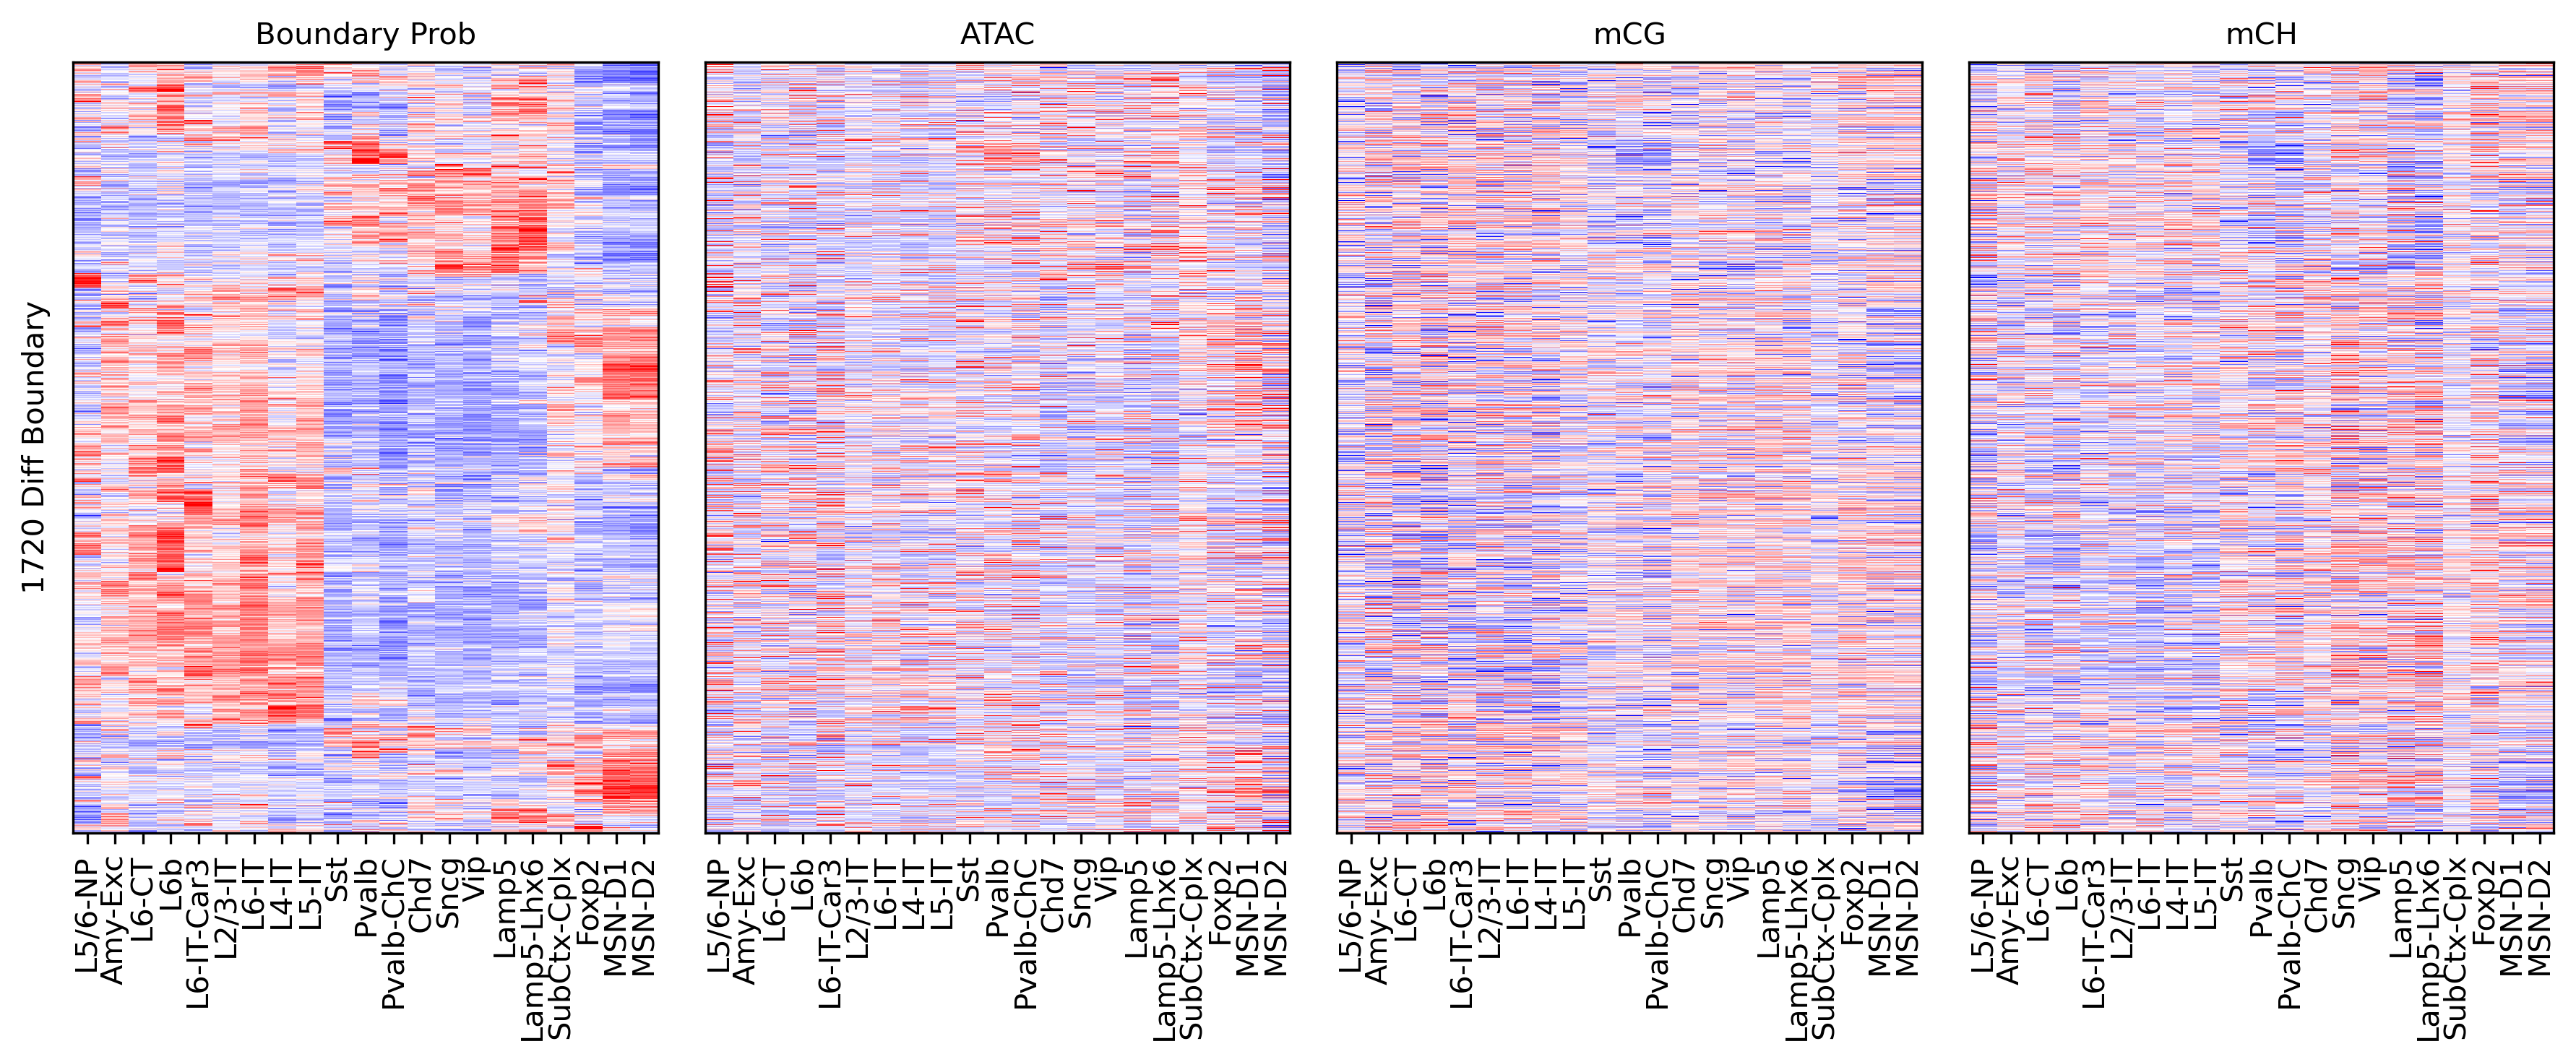

In [19]:
fig, axes = plt.subplots(1, 4, sharey='all', figsize=(12,5), dpi=300)

ax = axes[0]
ax.imshow(tmp3c[np.ix_(rorder, corder)], cmap='bwr', aspect='auto', vmin=-3, vmax=3, interpolation='none')
ax.set_title('Boundary Prob', fontsize=10)
# sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks(np.arange(len(leg)))
ax.set_xticklabels(legname[corder], rotation=90)
ax.set_yticks([])
ax.set_ylabel(f'{tmp3c.shape[0]} Diff Boundary')

ax = axes[1]
ax.imshow(tmpatac[np.ix_(rorder, corderatac)], cmap='bwr', aspect='auto', vmin=-3, vmax=3, interpolation='none')
ax.set_title('ATAC', fontsize=10)
# sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks(np.arange(len(legatac)))
ax.set_xticklabels(legname[corderatac], rotation=90)

ax = axes[2]
ax.imshow(tmpcg[np.ix_(rorder, corder)], cmap='bwr', aspect='auto', vmin=-3, vmax=3, interpolation='none')
ax.set_title('mCG', fontsize=10)
# sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks(np.arange(len(leg)))
ax.set_xticklabels(legname[corder], rotation=90)

ax = axes[3]
ax.imshow(tmpch[np.ix_(rorder, corder)], cmap='bwr', aspect='auto', vmin=-3, vmax=3, interpolation='none')
ax.set_title('mCH', fontsize=10)
# sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks(np.arange(len(leg)))
ax.set_xticklabels(legname[corder], rotation=90)


plt.tight_layout()
# plt.savefig(f'majortype_{group_name}_diffbound_3C_Epi.pdf', transparent=True)


Text(0, 0.5, 'PCC with Comp Score')

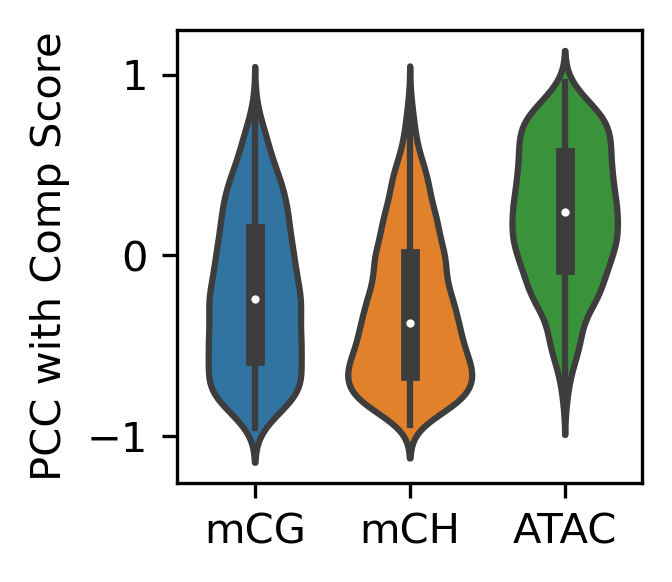

In [20]:
fig, ax = plt.subplots(figsize=(2,2), dpi=300)
sns.violinplot([binall.loc[selb, 'mCG_corr'], 
                binall.loc[selb, 'mCH_corr'], 
                binall.loc[selb, 'ATAC_corr']], ax=ax)
ax.set_xticklabels(['mCG', 'mCH', 'ATAC'])
ax.set_ylabel('PCC with Comp Score')
# plt.savefig(f'majortype_{group_name}_diffbound_epicorr.pdf', transparent=True)


In [21]:
print(binall.loc[selb, 'mCG_corr'].median(), 
      binall.loc[selb, 'mCH_corr'].median(),
      binall.loc[selb, 'ATAC_corr'].median(),
      selb.sum()
     )

-0.23891224792565977 -0.3763989220670755 0.2403007736648618 1720


## TSS stats vs corr

In [22]:
binall = binall.loc[binall['bklfilter'] & (binall['probdiff']>0)]
binall

,chrom,start,end,bklfilter,chi2filter,ins_lm,probdiff,chi2_sc,insfc,diff_sc,mCG_corr,mCH_corr,ATAC_corr
chr1_34,chr1,850000,875000,True,False,0,0.001558,11.570785,0.281549,0,0.484103,0.355741,-0.332018
chr1_35,chr1,875000,900000,True,False,0,0.007333,17.110812,0.258256,0,-0.663989,0.268799,0.316048
chr1_36,chr1,900000,925000,True,False,0,0.019086,36.136662,0.247746,0,-0.188664,0.174081,-0.036786
chr1_37,chr1,925000,950000,True,False,0,0.022342,45.028810,0.244715,0,-0.539621,-0.432163,0.519192
chr1_38,chr1,950000,975000,True,False,0,0.021296,28.239344,0.252528,0,0.000574,-0.178776,0.467298
...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr22_2018,chr22,50450000,50475000,True,False,0,0.032081,45.797538,0.407091,0,0.418948,-0.172765,-0.349786
chr22_2019,chr22,50475000,50500000,True,False,0,0.047843,54.166764,0.393158,0,0.330239,-0.480359,0.063941
chr22_2020,chr22,50500000,50525000,True,False,1,0.050676,59.499545,0.374385,0,0.191173,-0.305744,0.146097
chr22_2021,chr22,50525000,50550000,True,False,1,0.058912,61.681386,0.356571,1,-0.222545,-0.253223,0.409311


In [23]:
expr = pd.read_hdf('/home/jzhou_salk_edu/sky_workdir/hba/rna_majortype/cluster_expr.hdf')
stats = pd.read_hdf(f'/home/jzhou_salk_edu/sky_workdir/hba/rna_majortype/{group_name}_deg_stats.hdf')
genefilter = (stats['stats']>0)
expr = expr.loc[:, genefilter]
stats = stats.loc[genefilter]


In [24]:
data = pd.read_csv(f'/home/jzhou_salk_edu/sky_workdir/hba/ref/hg38.main.5kbin.TSS.slop2k.txt', sep='\t', header=None, index_col=None)
data = data.loc[(data[1] % res)!=10000]
data['bin_id'] = data[0] + '_' + ((data[1] + 10000) // res).astype(str)
data = data.rename({6:'gene_id'}, axis=1)
data = data[['bin_id', 'gene_id']].drop_duplicates()
data = data.loc[(data['bin_id'].isin(binall.index)) & (data['gene_id'].isin(stats.index))]
data['chi2'] = binall.loc[data['bin_id'].values, 'chi2_sc'].values
data['kruskal'] = stats.loc[data['gene_id'].values, 'stats'].values


In [25]:
tmp3c = bound_prob_ct.loc[data['bin_id'].values].values
tmp3c = zscore(tmp3c, axis=1)


In [26]:
tmprna = expr.loc[leg, data['gene_id'].values].T.values
tmprna = zscore(tmprna, axis=1)


In [27]:
data['corr'] = [pearsonr(xx, yy)[0] for xx,yy in zip(tmp3c, tmprna)]

<AxesSubplot:xlabel='chi2', ylabel='kruskal'>

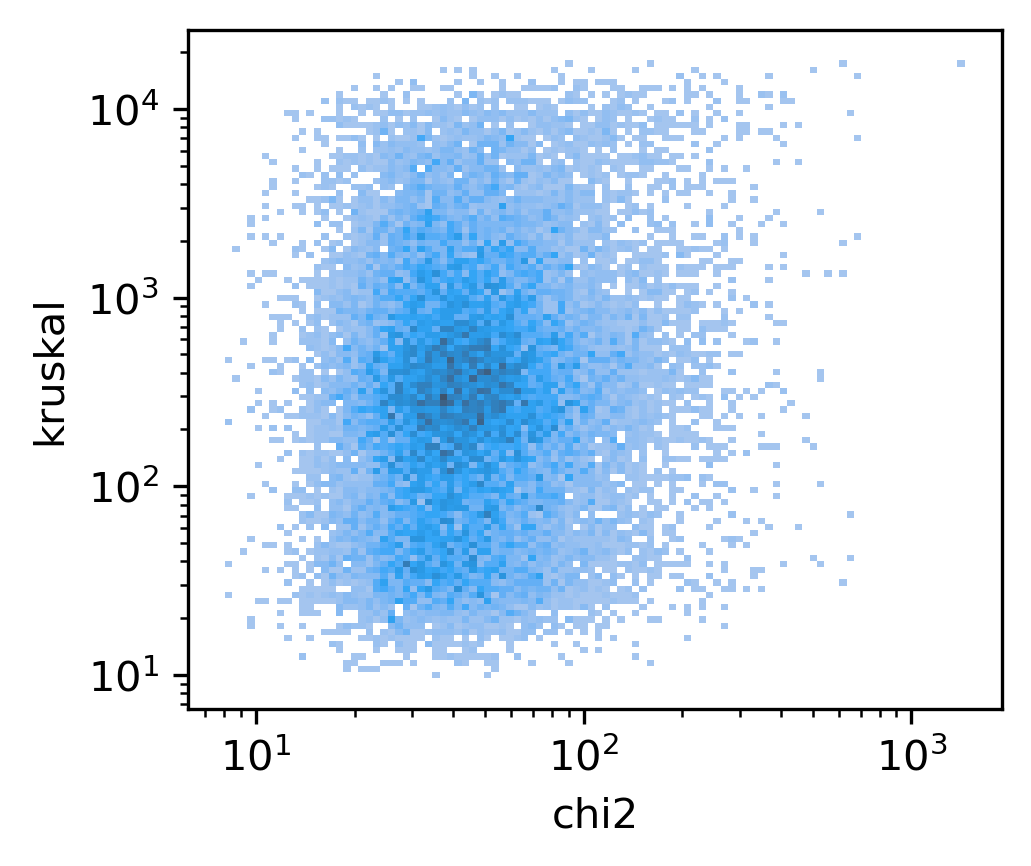

In [28]:
fig, ax = plt.subplots(figsize=(3.5,3), dpi=300)
sns.histplot(data, x='chi2', y='kruskal', bins=100, ax=ax, log_scale=(10,10))


In [29]:
data['chi2_group'], groupM = pd.cut(zscore(np.log10(data['chi2'])), 100, labels=False, retbins=True)
data['kruskal_group'], groupK = pd.cut(zscore(np.log10(data['kruskal'])), 100, labels=False, retbins=True)


In [30]:
tmp = data.groupby(['chi2_group','kruskal_group'])['corr'].mean()
groupcorr = np.zeros((100, 100)) / 0
groupcorr[(tmp.index.get_level_values('kruskal_group'), tmp.index.get_level_values('chi2_group'))] = tmp.values


In [31]:
tmp = data.groupby(['chi2_group','kruskal_group'])['corr'].count()
groupcount = np.zeros((100, 100))
groupcount[(tmp.index.get_level_values('kruskal_group'), tmp.index.get_level_values('chi2_group'))] = tmp.values + 1


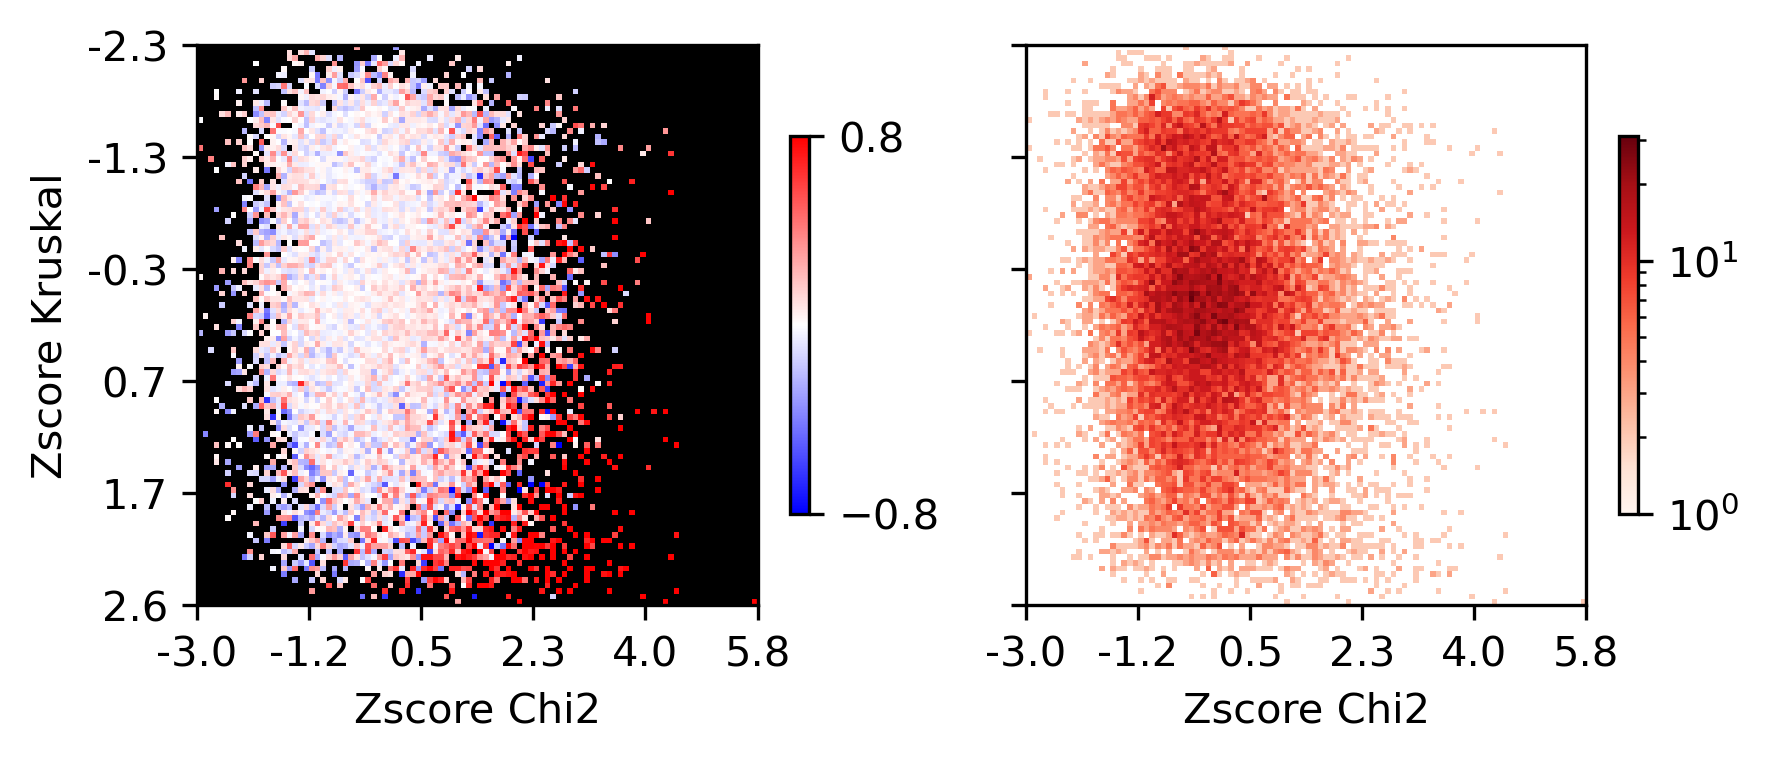

In [32]:
cmap = mpl.cm.bwr
cmap.set_bad('black', 1.0)

fig, axes = plt.subplots(1, 2, figsize=(6,3), sharex='all', sharey='all', dpi=300)
ax = axes[0]
plot = ax.imshow(groupcorr, vmin=-0.8, vmax=0.8, cmap=cmap)

cbar = fig.colorbar(plot, ax=ax, shrink=0.5, fraction=0.1)
cbar.set_ticks([-0.8, 0.8])
ax.set_xlabel('Zscore Chi2')
ax.set_ylabel('Zscore Kruskal')

ax = axes[1]
plot = ax.imshow(groupcount, cmap='Reds', norm=LogNorm(vmin=1))
fig.colorbar(plot, ax=ax, shrink=0.5, fraction=0.1)
ax.set_xticks(np.arange(-0.5, 100.5, 20))
ax.set_yticks(np.arange(-0.5, 100.5, 20))
ax.set_xticklabels(np.around(groupM[np.arange(0,100.5,20).astype(int)], decimals=1))
ax.set_yticklabels(np.around(groupK[np.arange(0,100.5,20).astype(int)], decimals=1))

ax.set_xlabel('Zscore Chi2')
plt.tight_layout()
# plt.savefig(f'majortype_{group_name}_bound_rna_stats_tss_corr.pdf', transparent=True)


## Differential Loop vs All Gene TSS

In [33]:
corr_all = []

In [34]:
selp = data['bin_id'].isin(selb.index[selb])
data = data.loc[selp]

In [35]:
tmp3c = tmp3c[selp]
tmprna = tmprna[selp]

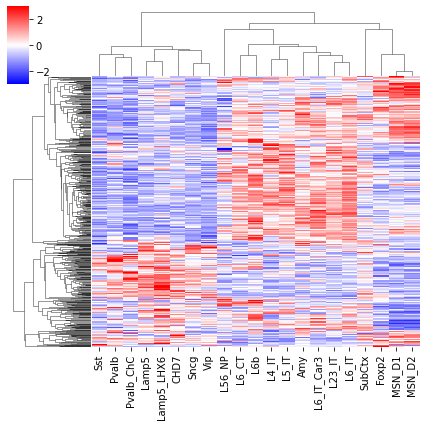

In [36]:
cg = sns.clustermap(tmp3c, cmap='bwr', vmin=-3, vmax=3, metric='cosine', xticklabels=leg, yticklabels=[], figsize=(6,6))


In [37]:
rorder = cg.dendrogram_row.reordered_ind.copy()
corder = cg.dendrogram_col.reordered_ind.copy()

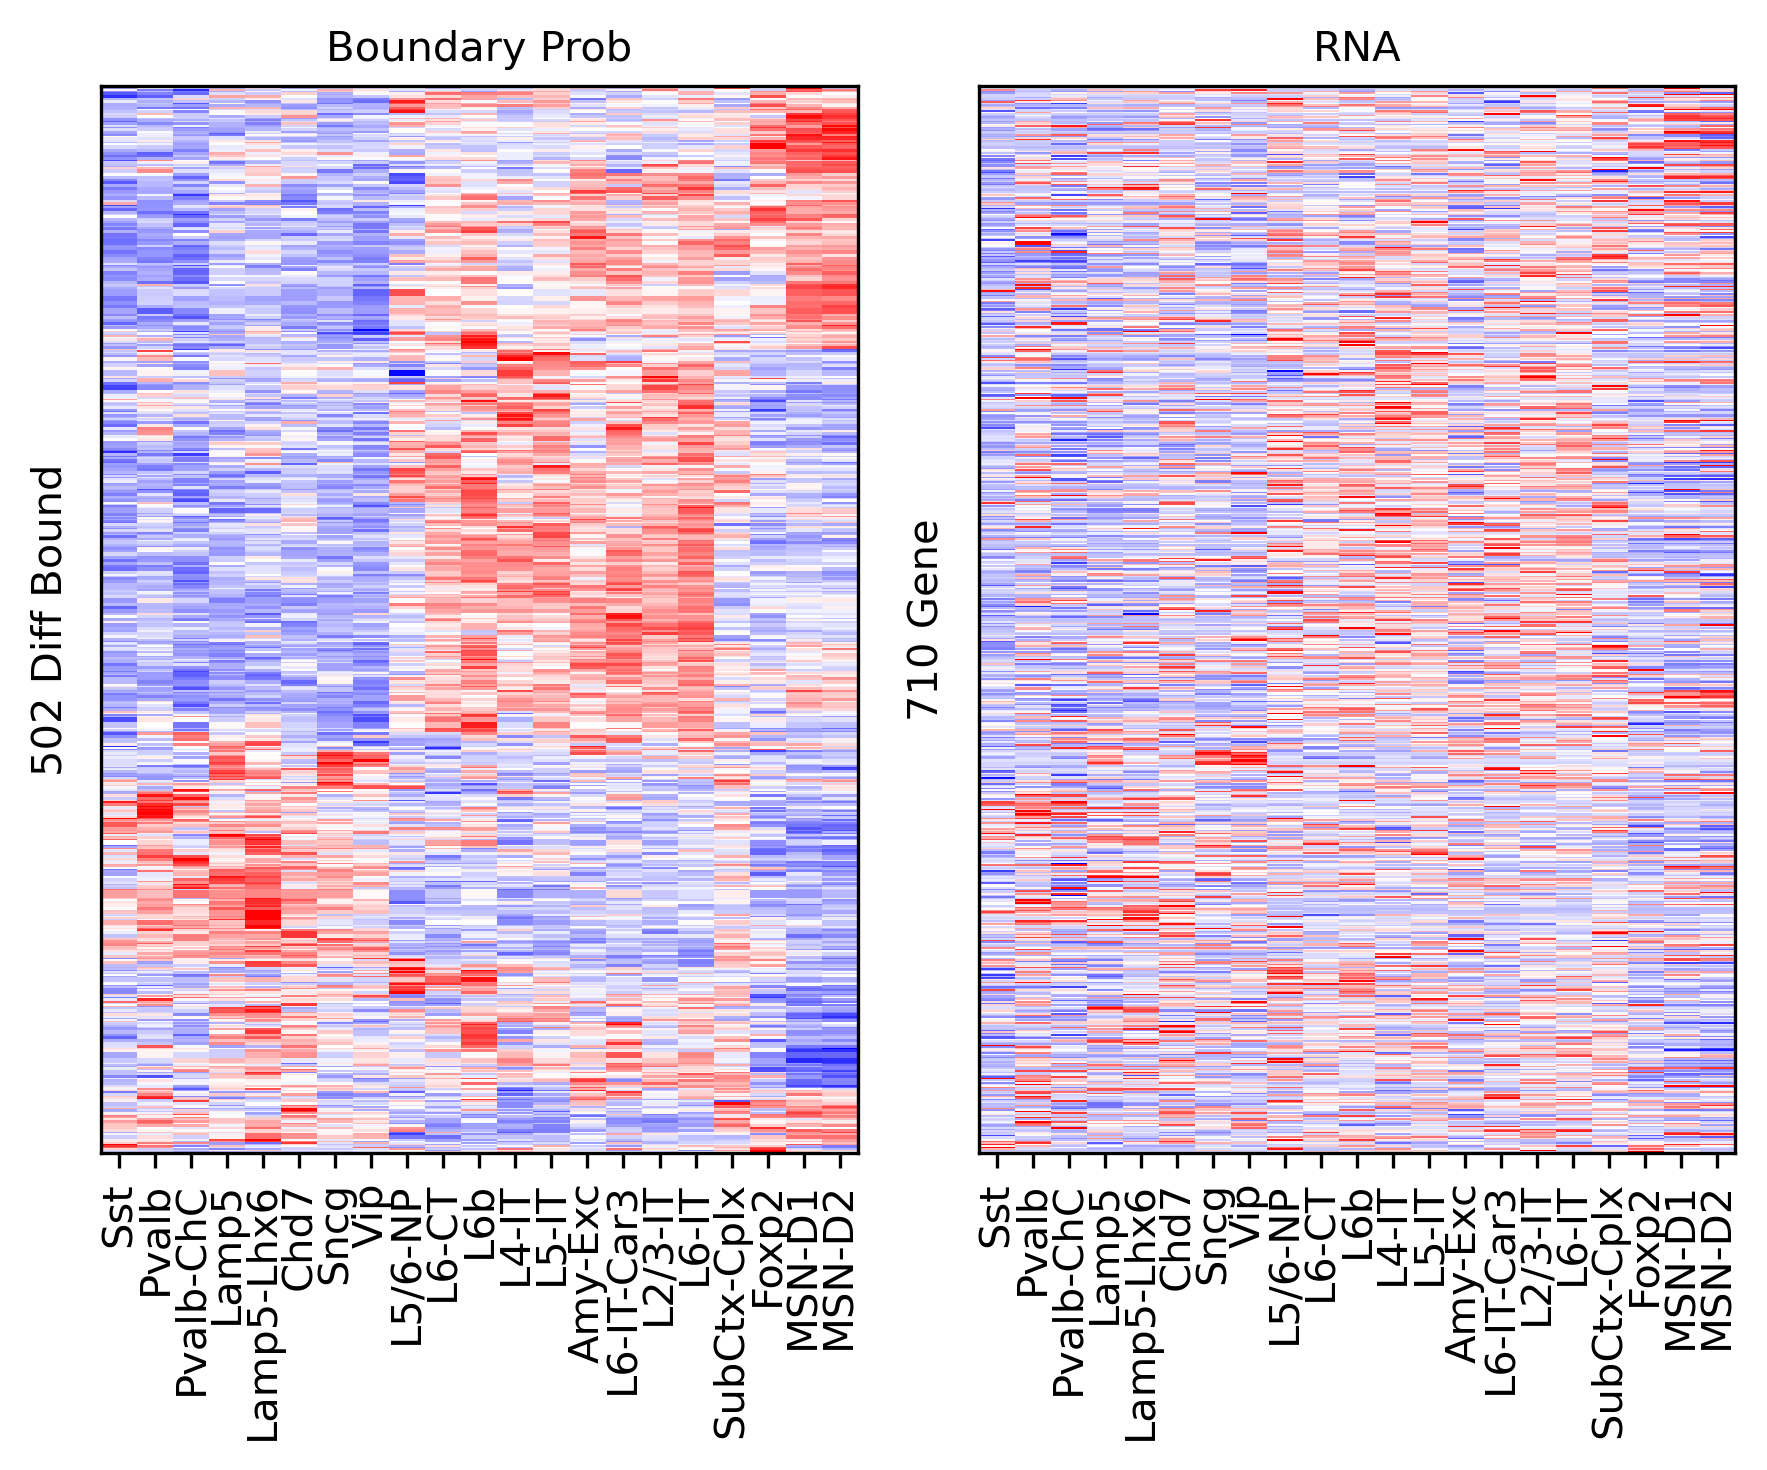

In [38]:
fig, axes = plt.subplots(1, 2, sharey='all', figsize=(6,5), dpi=300)

ax = axes[0]
ax.imshow(tmp3c[np.ix_(rorder, corder)], cmap='bwr', aspect='auto', vmin=-3, vmax=3, interpolation='none')
ax.set_title('Boundary Prob', fontsize=10)
# sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks(np.arange(len(leg)))
ax.set_xticklabels(legname[corder], rotation=90)
ax.set_yticks([])
ax.set_ylabel(f'{np.unique(data["bin_id"]).shape[0]} Diff Bound')

ax = axes[1]
ax.imshow(tmprna[np.ix_(rorder, corder)], cmap='bwr', aspect='auto', vmin=-3, vmax=3, interpolation='none')
ax.set_title('RNA', fontsize=10)
# sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks(np.arange(len(leg)))
ax.set_xticklabels(legname[corder], rotation=90)
ax.set_ylabel(f'{np.unique(data["gene_id"]).shape[0]} Gene')

plt.tight_layout()
# plt.savefig(f'majortype_{group_name}_diffbound_3C_RNA_alltss.pdf', transparent=True)


In [39]:
corr_all.append(data['corr'].values)


## Differential Loop vs DEG TSS

In [40]:
from scipy.stats import rankdata

deg = np.zeros(genefilter.shape[0])
for i in range(len(leg)-1):
    for j in range(i+1, len(leg)):
        tmp = np.load(f'/home/jzhou_salk_edu/sky_workdir/hba/rna_majortype/DEG/{leg[i]}-{leg[j]}.npz')
        # deg[np.logical_and(np.abs(tmp['fc'])>1, tmp['fdr']<1e-3)] = 1
        rank = rankdata(tmp['fdr'])
        deg[rank<=100] = 1

print(deg.sum())

1131.0


In [41]:
tmp = anndata.read_h5ad('/home/jzhou_salk_edu/sky_workdir/hba/rna_majortype/cell_29000_rna.h5ad')


In [43]:
tmp.var['DEG'] = deg.copy()
# ((tmp.var['chrom'].isin(chrom_sizes.index)) & (tmp.var['DEG']==1) & genefilter).sum()

In [44]:
selp = data['gene_id'].isin(genefilter.index[deg==1])
data = data.loc[selp]

In [45]:
tmp3c = tmp3c[selp]
tmprna = tmprna[selp]

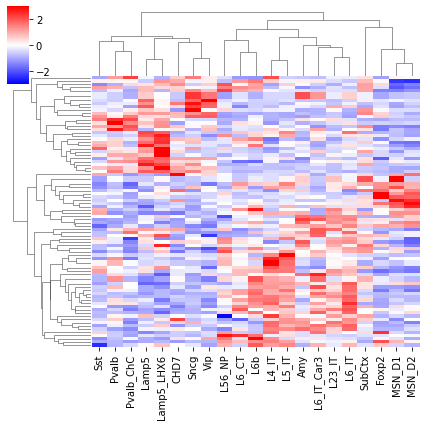

In [46]:
cg = sns.clustermap(tmp3c, cmap='bwr', vmin=-3, vmax=3, metric='cosine', xticklabels=leg, yticklabels=[], figsize=(6,6))


In [47]:
rorder = cg.dendrogram_row.reordered_ind.copy()
corder = cg.dendrogram_col.reordered_ind.copy()

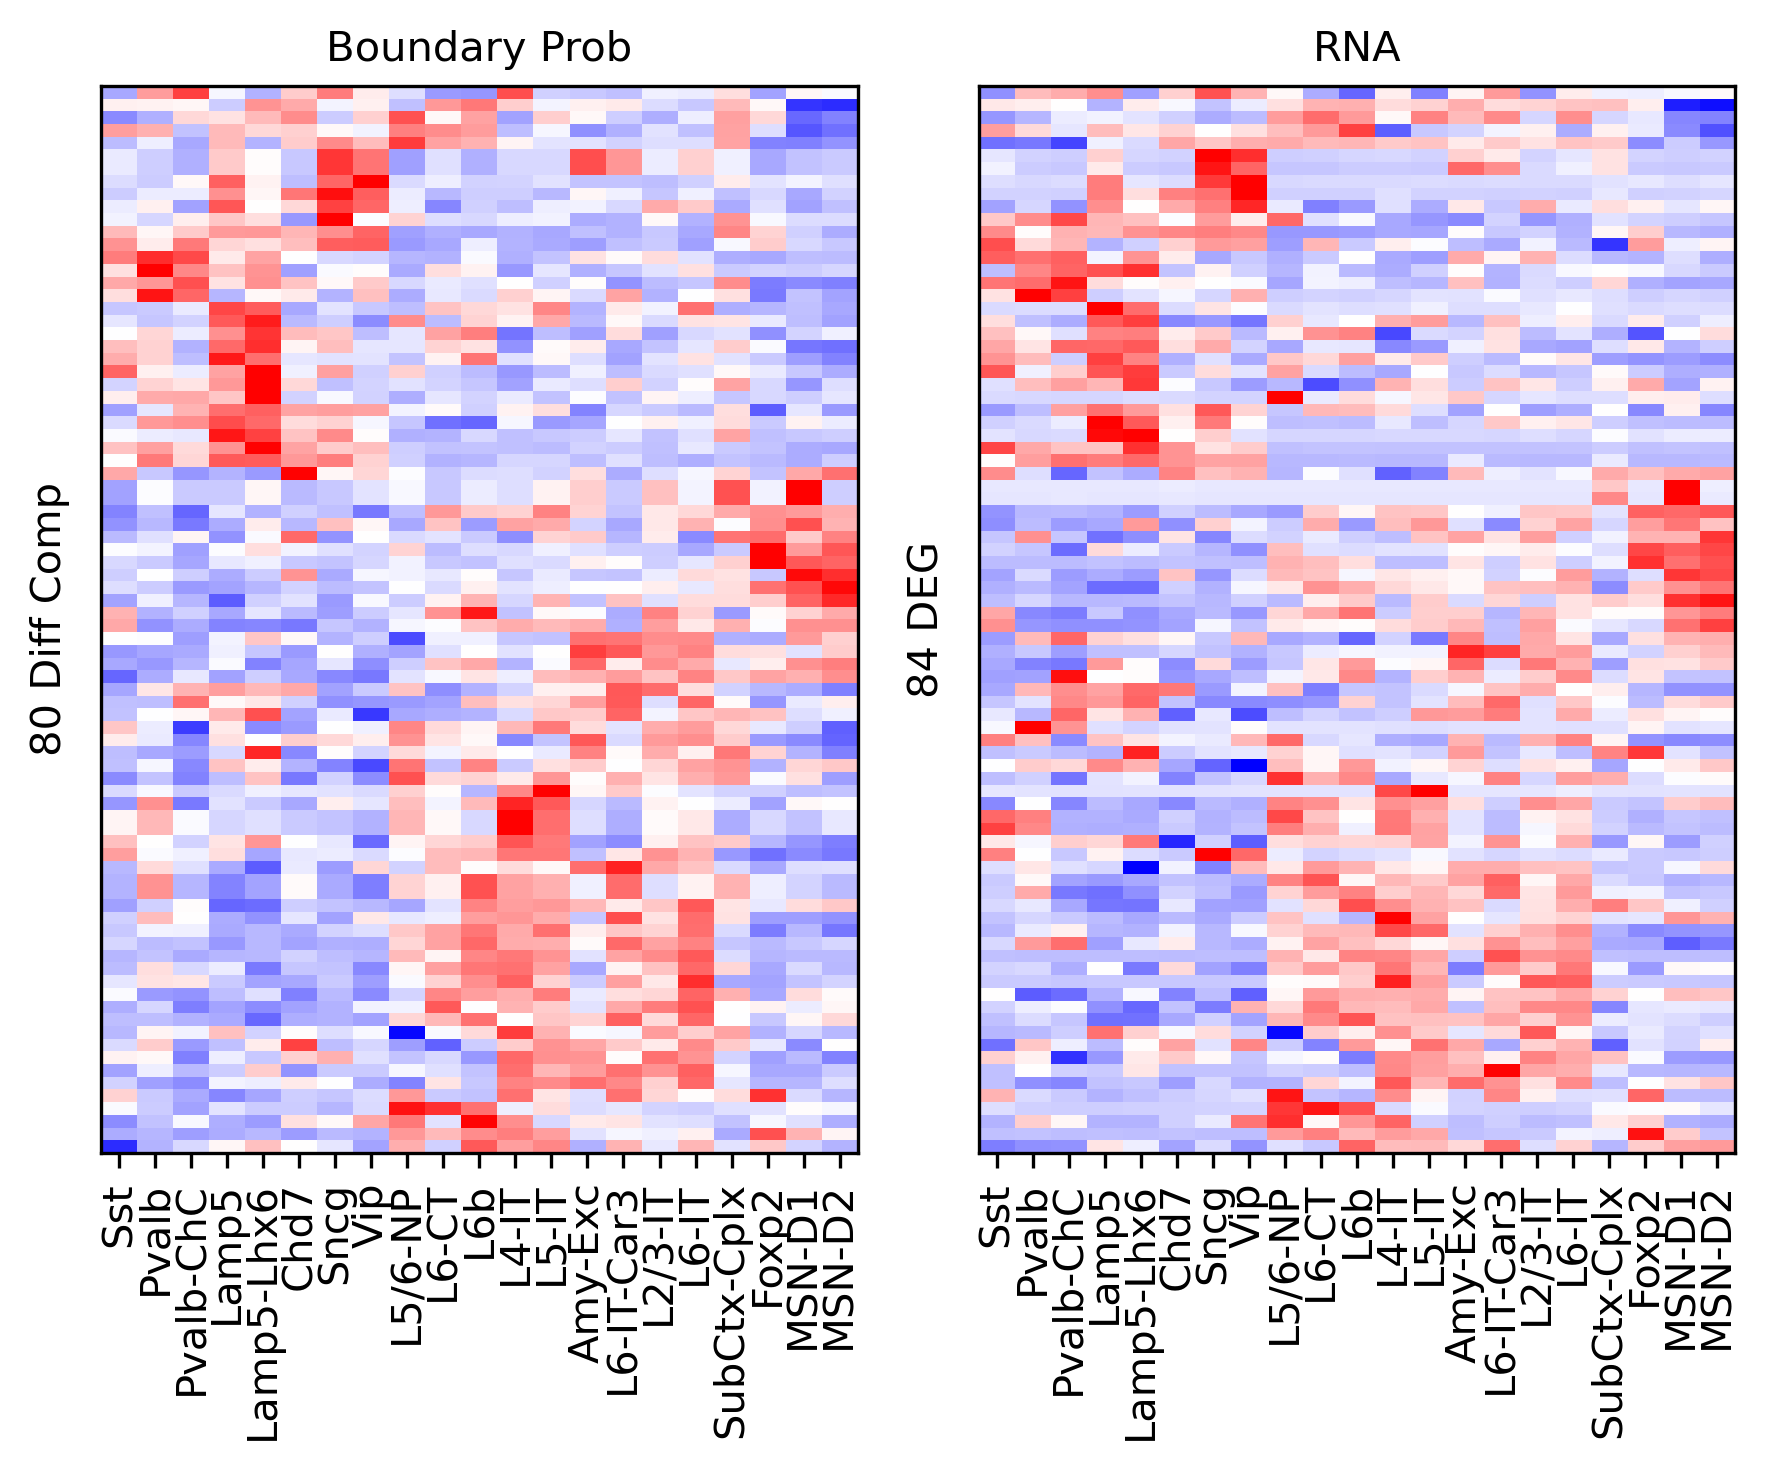

In [48]:
fig, axes = plt.subplots(1, 2, sharey='all', figsize=(6,5), dpi=300)

ax = axes[0]
ax.imshow(tmp3c[np.ix_(rorder, corder)], cmap='bwr', aspect='auto', vmin=-3, vmax=3, interpolation='none')
ax.set_title('Boundary Prob', fontsize=10)
# sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks(np.arange(len(leg)))
ax.set_xticklabels(legname[corder], rotation=90)
ax.set_yticks([])
ax.set_ylabel(f'{np.unique(data["bin_id"]).shape[0]} Diff Comp')

ax = axes[1]
ax.imshow(tmprna[np.ix_(rorder, corder)], cmap='bwr', aspect='auto', vmin=-3, vmax=3, interpolation='none')
ax.set_title('RNA', fontsize=10)
# sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks(np.arange(len(leg)))
ax.set_xticklabels(legname[corder], rotation=90)
ax.set_ylabel(f'{np.unique(data["gene_id"]).shape[0]} DEG')

plt.tight_layout()
# plt.savefig(f'majortype_{group_name}_diffbound_3C_RNA_degtss.pdf', transparent=True)


In [49]:
corr_all.append(data['corr'].values)


## Gene body stats vs corr

In [50]:
expr = pd.read_hdf('/home/jzhou_salk_edu/sky_workdir/hba/rna_majortype/cluster_expr.hdf')
stats = pd.read_hdf(f'/home/jzhou_salk_edu/sky_workdir/hba/rna_majortype/{group_name}_deg_stats.hdf')
genefilter = (stats['stats']>0)
expr = expr.loc[:, genefilter]
stats = stats.loc[genefilter]


In [51]:
data = pd.read_csv(f'/home/jzhou_salk_edu/sky_workdir/hba/ref/hg38.main.5kbin.gene.slop2k.txt', sep='\t', header=None, index_col=None)
data = data.loc[(data[1] % res)!=10000]
data['bin_id'] = data[0] + '_' + ((data[1] + 10000) // res).astype(str)
data = data.rename({6:'gene_id'}, axis=1)
data = data[['bin_id', 'gene_id']].drop_duplicates()
data = data.loc[(data['bin_id'].isin(binall.index)) & (data['gene_id'].isin(stats.index))]
data['chi2'] = binall.loc[data['bin_id'].values, 'chi2_sc'].values
data['kruskal'] = stats.loc[data['gene_id'].values, 'stats'].values


In [52]:
tmp3c = bound_prob_ct.loc[data['bin_id'].values].values
tmp3c = zscore(tmp3c, axis=1)


In [53]:
tmprna = expr.loc[leg, data['gene_id'].values].T.values
tmprna = zscore(tmprna, axis=1)


In [54]:
data['corr'] = [pearsonr(xx, yy)[0] for xx,yy in zip(tmp3c, tmprna)]


<AxesSubplot:xlabel='chi2', ylabel='kruskal'>

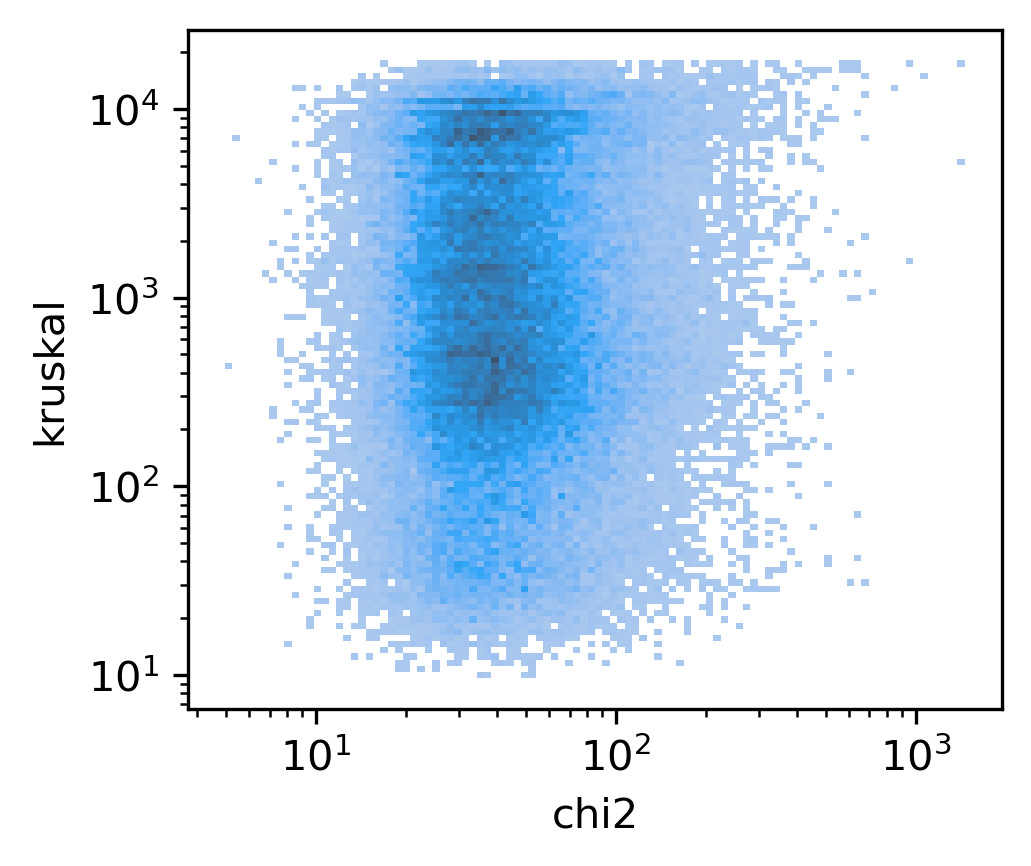

In [55]:
fig, ax = plt.subplots(figsize=(3.5,3), dpi=300)
sns.histplot(data, x='chi2', y='kruskal', bins=100, ax=ax, log_scale=(10,10))


In [56]:
data['chi2_group'], groupM = pd.cut(zscore(np.log10(data['chi2'])), 100, labels=False, retbins=True)
data['kruskal_group'], groupK = pd.cut(zscore(np.log10(data['kruskal'])), 100, labels=False, retbins=True)


In [57]:
tmp = data.groupby(['chi2_group','kruskal_group'])['corr'].mean()
groupcorr = np.zeros((100, 100)) / 0
groupcorr[(tmp.index.get_level_values('kruskal_group'), tmp.index.get_level_values('chi2_group'))] = tmp.values


In [58]:
tmp = data.groupby(['chi2_group','kruskal_group'])['corr'].count()
groupcount = np.zeros((100, 100))
groupcount[(tmp.index.get_level_values('kruskal_group'), tmp.index.get_level_values('chi2_group'))] = tmp.values + 1


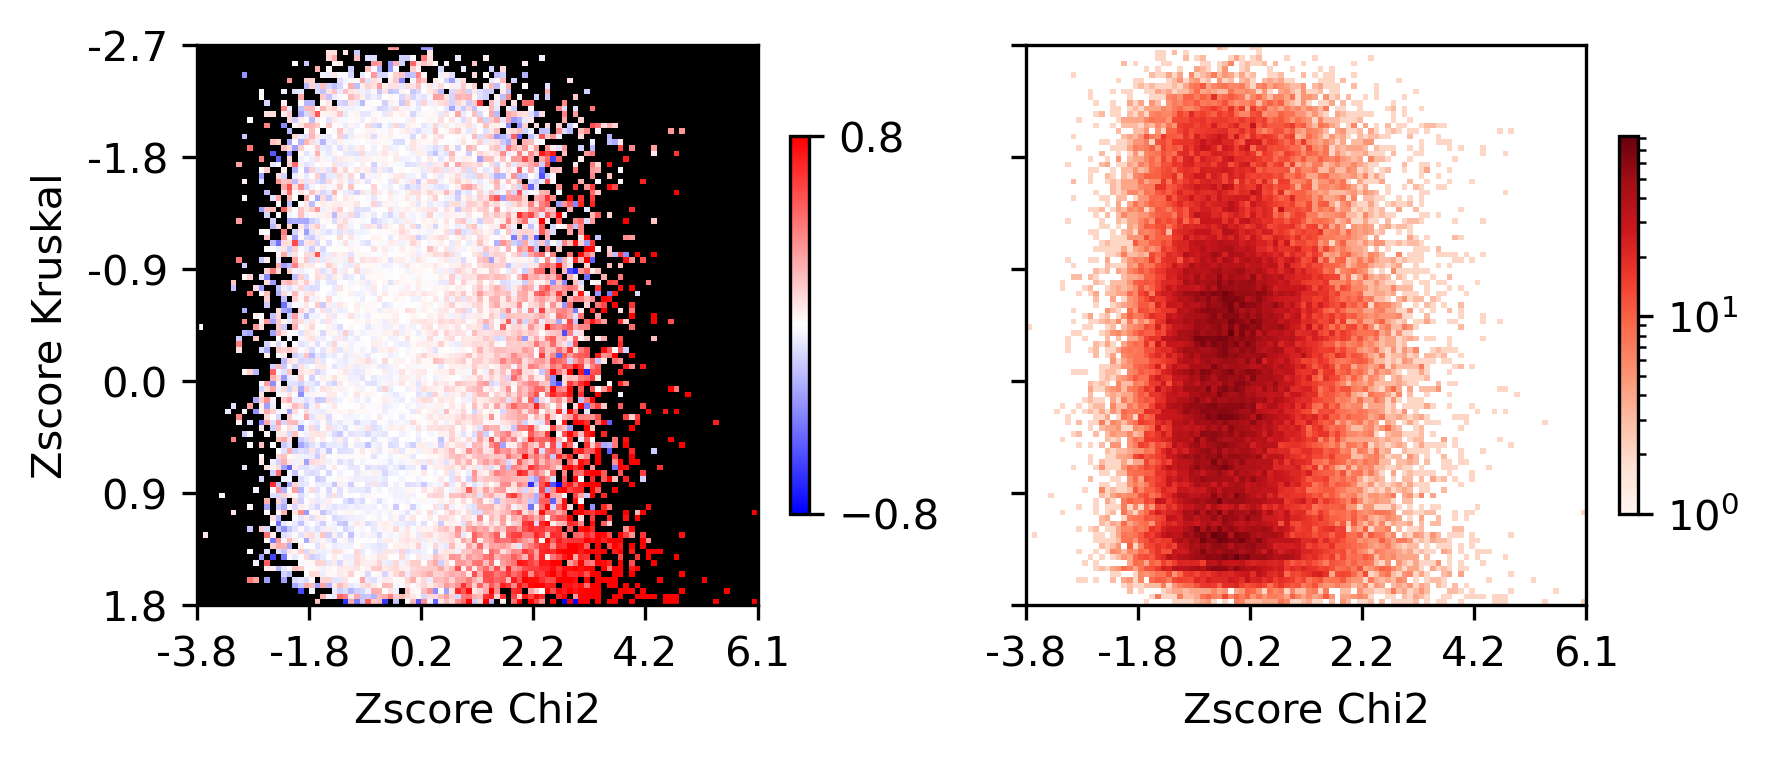

In [59]:
cmap = mpl.cm.bwr
cmap.set_bad('black', 1.0)

fig, axes = plt.subplots(1, 2, figsize=(6,3), sharex='all', sharey='all', dpi=300)
ax = axes[0]
plot = ax.imshow(groupcorr, vmin=-0.8, vmax=0.8, cmap=cmap)

cbar = fig.colorbar(plot, ax=ax, shrink=0.5, fraction=0.1)
cbar.set_ticks([-0.8, 0.8])
ax.set_xlabel('Zscore Chi2')
ax.set_ylabel('Zscore Kruskal')

ax = axes[1]
plot = ax.imshow(groupcount, cmap='Reds', norm=LogNorm(vmin=1))
fig.colorbar(plot, ax=ax, shrink=0.5, fraction=0.1)
ax.set_xticks(np.arange(-0.5, 100.5, 20))
ax.set_yticks(np.arange(-0.5, 100.5, 20))
ax.set_xticklabels(np.around(groupM[np.arange(0,100.5,20).astype(int)], decimals=1))
ax.set_yticklabels(np.around(groupK[np.arange(0,100.5,20).astype(int)], decimals=1))

ax.set_xlabel('Zscore Chi2')
plt.tight_layout()
# plt.savefig(f'majortype_{group_name}_bound_rna_stats_genebody_corr.pdf', transparent=True)


## Differential Loop vs All Gene Body

In [60]:
selp = data['bin_id'].isin(selb.index[selb])
data = data.loc[selp]

In [61]:
tmp3c = tmp3c[selp]
tmprna = tmprna[selp]

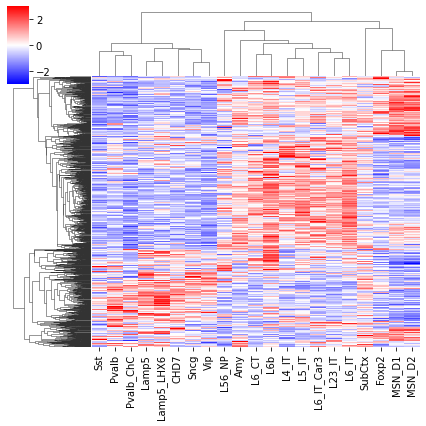

In [62]:
cg = sns.clustermap(tmp3c, cmap='bwr', vmin=-3, vmax=3, metric='cosine', xticklabels=leg, yticklabels=[], figsize=(6,6))


In [63]:
rorder = cg.dendrogram_row.reordered_ind.copy()
corder = cg.dendrogram_col.reordered_ind.copy()

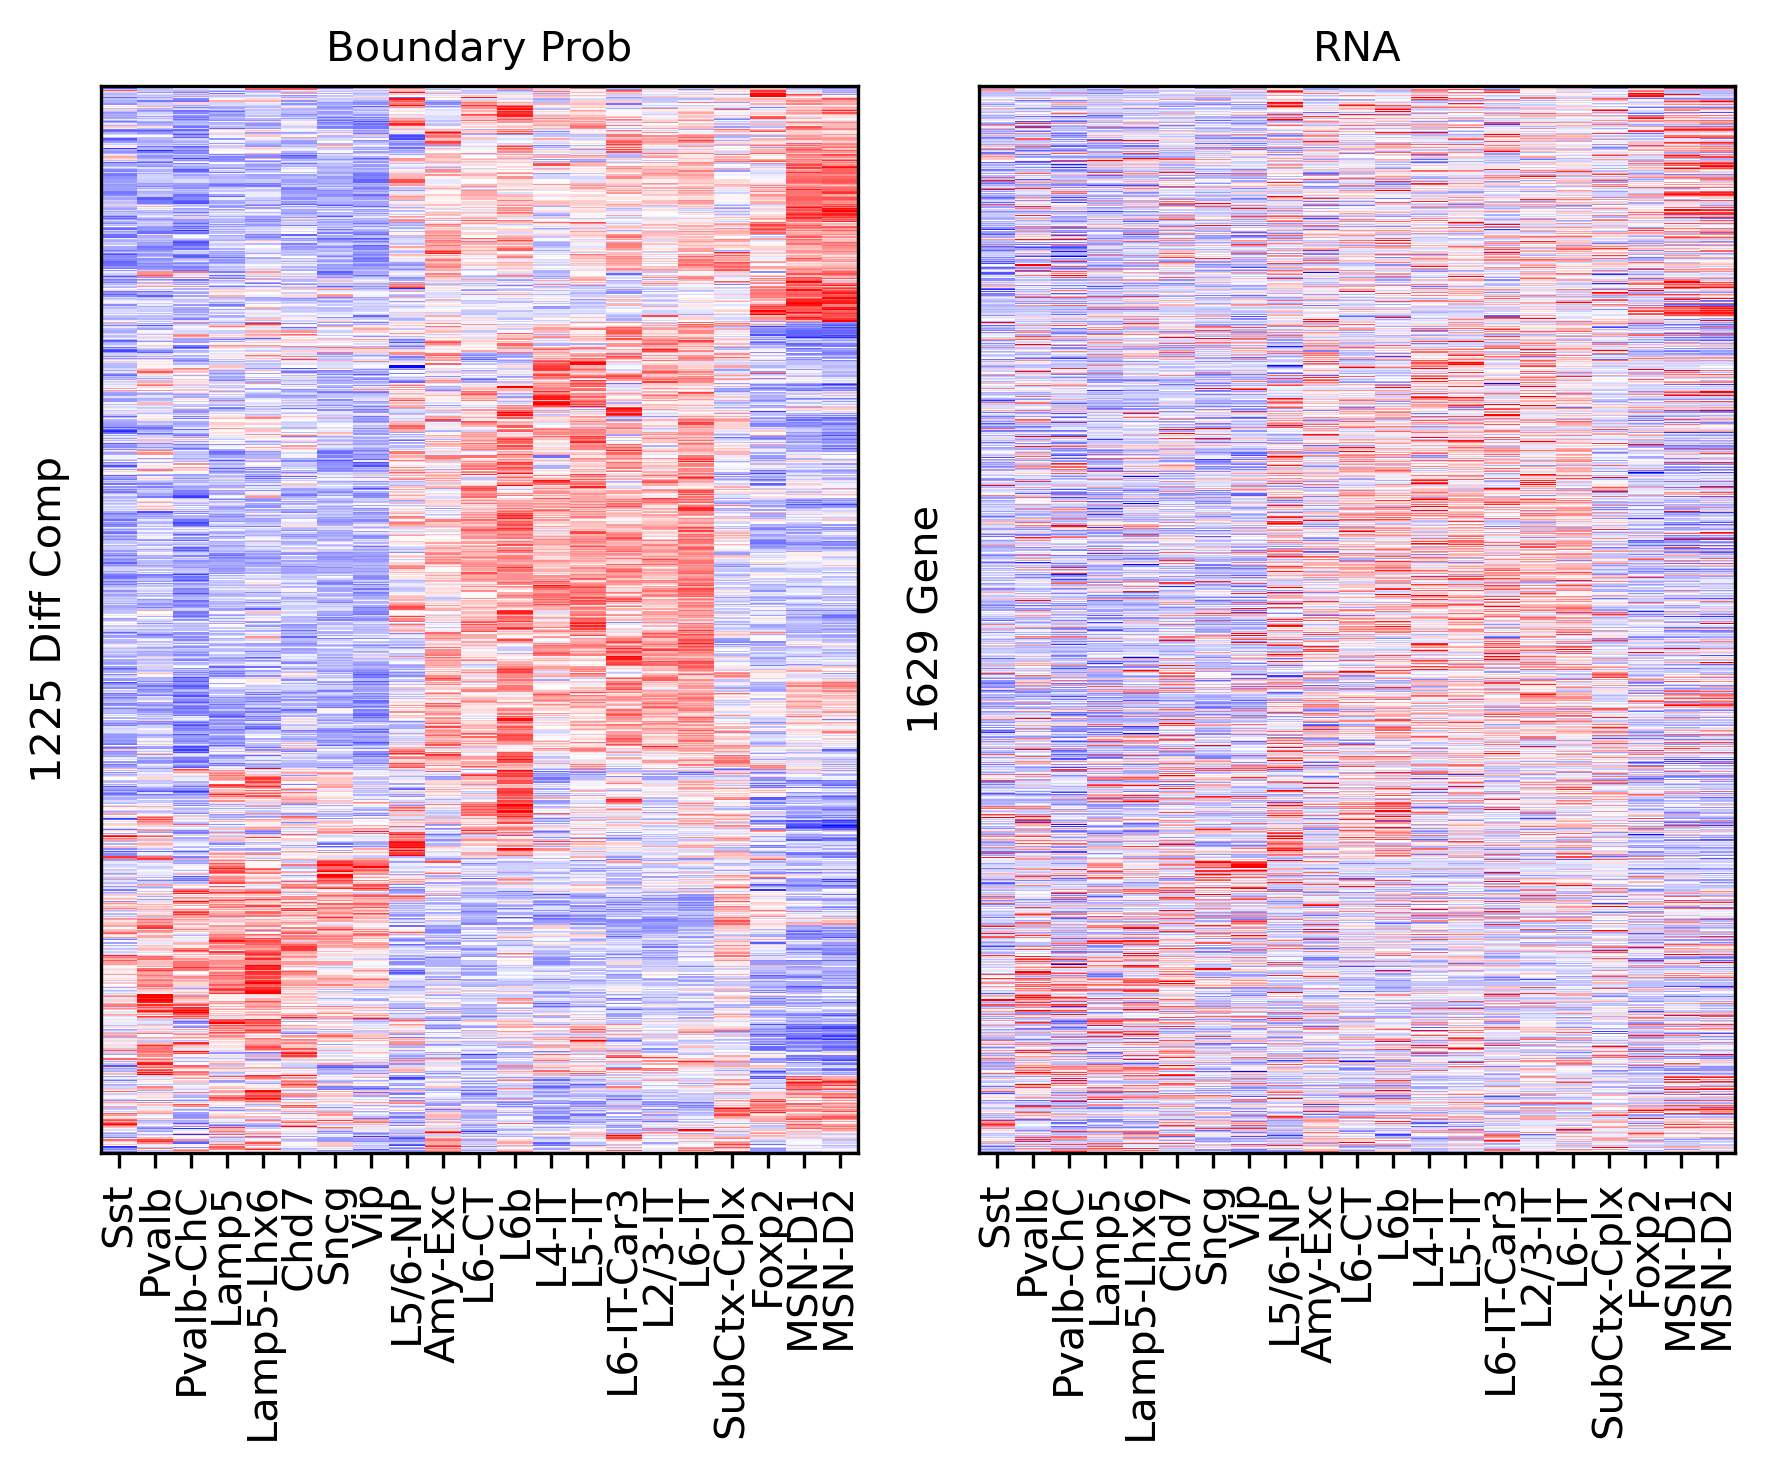

In [64]:
fig, axes = plt.subplots(1, 2, sharey='all', figsize=(6,5), dpi=300)

ax = axes[0]
ax.imshow(tmp3c[np.ix_(rorder, corder)], cmap='bwr', aspect='auto', vmin=-3, vmax=3, interpolation='none')
ax.set_title('Boundary Prob', fontsize=10)
# sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks(np.arange(len(leg)))
ax.set_xticklabels(legname[corder], rotation=90)
ax.set_yticks([])
ax.set_ylabel(f'{np.unique(data["bin_id"]).shape[0]} Diff Comp')

ax = axes[1]
ax.imshow(tmprna[np.ix_(rorder, corder)], cmap='bwr', aspect='auto', vmin=-3, vmax=3, interpolation='none')
ax.set_title('RNA', fontsize=10)
# sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks(np.arange(len(leg)))
ax.set_xticklabels(legname[corder], rotation=90)
ax.set_ylabel(f'{np.unique(data["gene_id"]).shape[0]} Gene')

plt.tight_layout()
# plt.savefig(f'majortype_{group_name}_diffbound_3C_RNA_allbody.pdf', transparent=True)


In [65]:
corr_all.append(data['corr'].values)


## Differential Loop vs DEG Gene Body

In [66]:
from scipy.stats import rankdata

deg = np.zeros(genefilter.shape[0])
for i in range(len(leg)-1):
    for j in range(i+1, len(leg)):
        tmp = np.load(f'/home/jzhou_salk_edu/sky_workdir/hba/rna_majortype/DEG/{leg[i]}-{leg[j]}.npz')
        # deg[np.logical_and(np.abs(tmp['fc'])>1, tmp['fdr']<1e-3)] = 1
        rank = rankdata(tmp['fdr'])
        deg[rank<=100] = 1

print(deg.sum())

1131.0


In [67]:
selp = data['gene_id'].isin(genefilter.index[deg==1])
data = data.loc[selp]

In [68]:
tmp3c = tmp3c[selp]
tmprna = tmprna[selp]

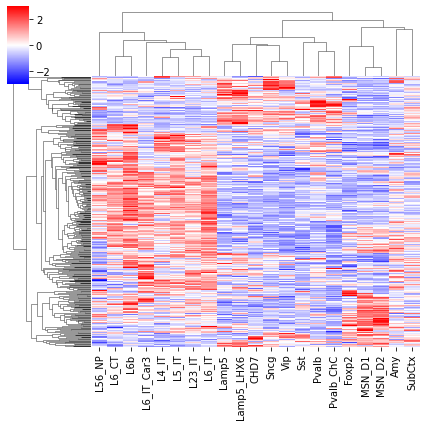

In [69]:
cg = sns.clustermap(tmp3c, cmap='bwr', vmin=-3, vmax=3, metric='cosine', xticklabels=leg, yticklabels=[], figsize=(6,6))


In [70]:
rorder = cg.dendrogram_row.reordered_ind.copy()
corder = cg.dendrogram_col.reordered_ind.copy()

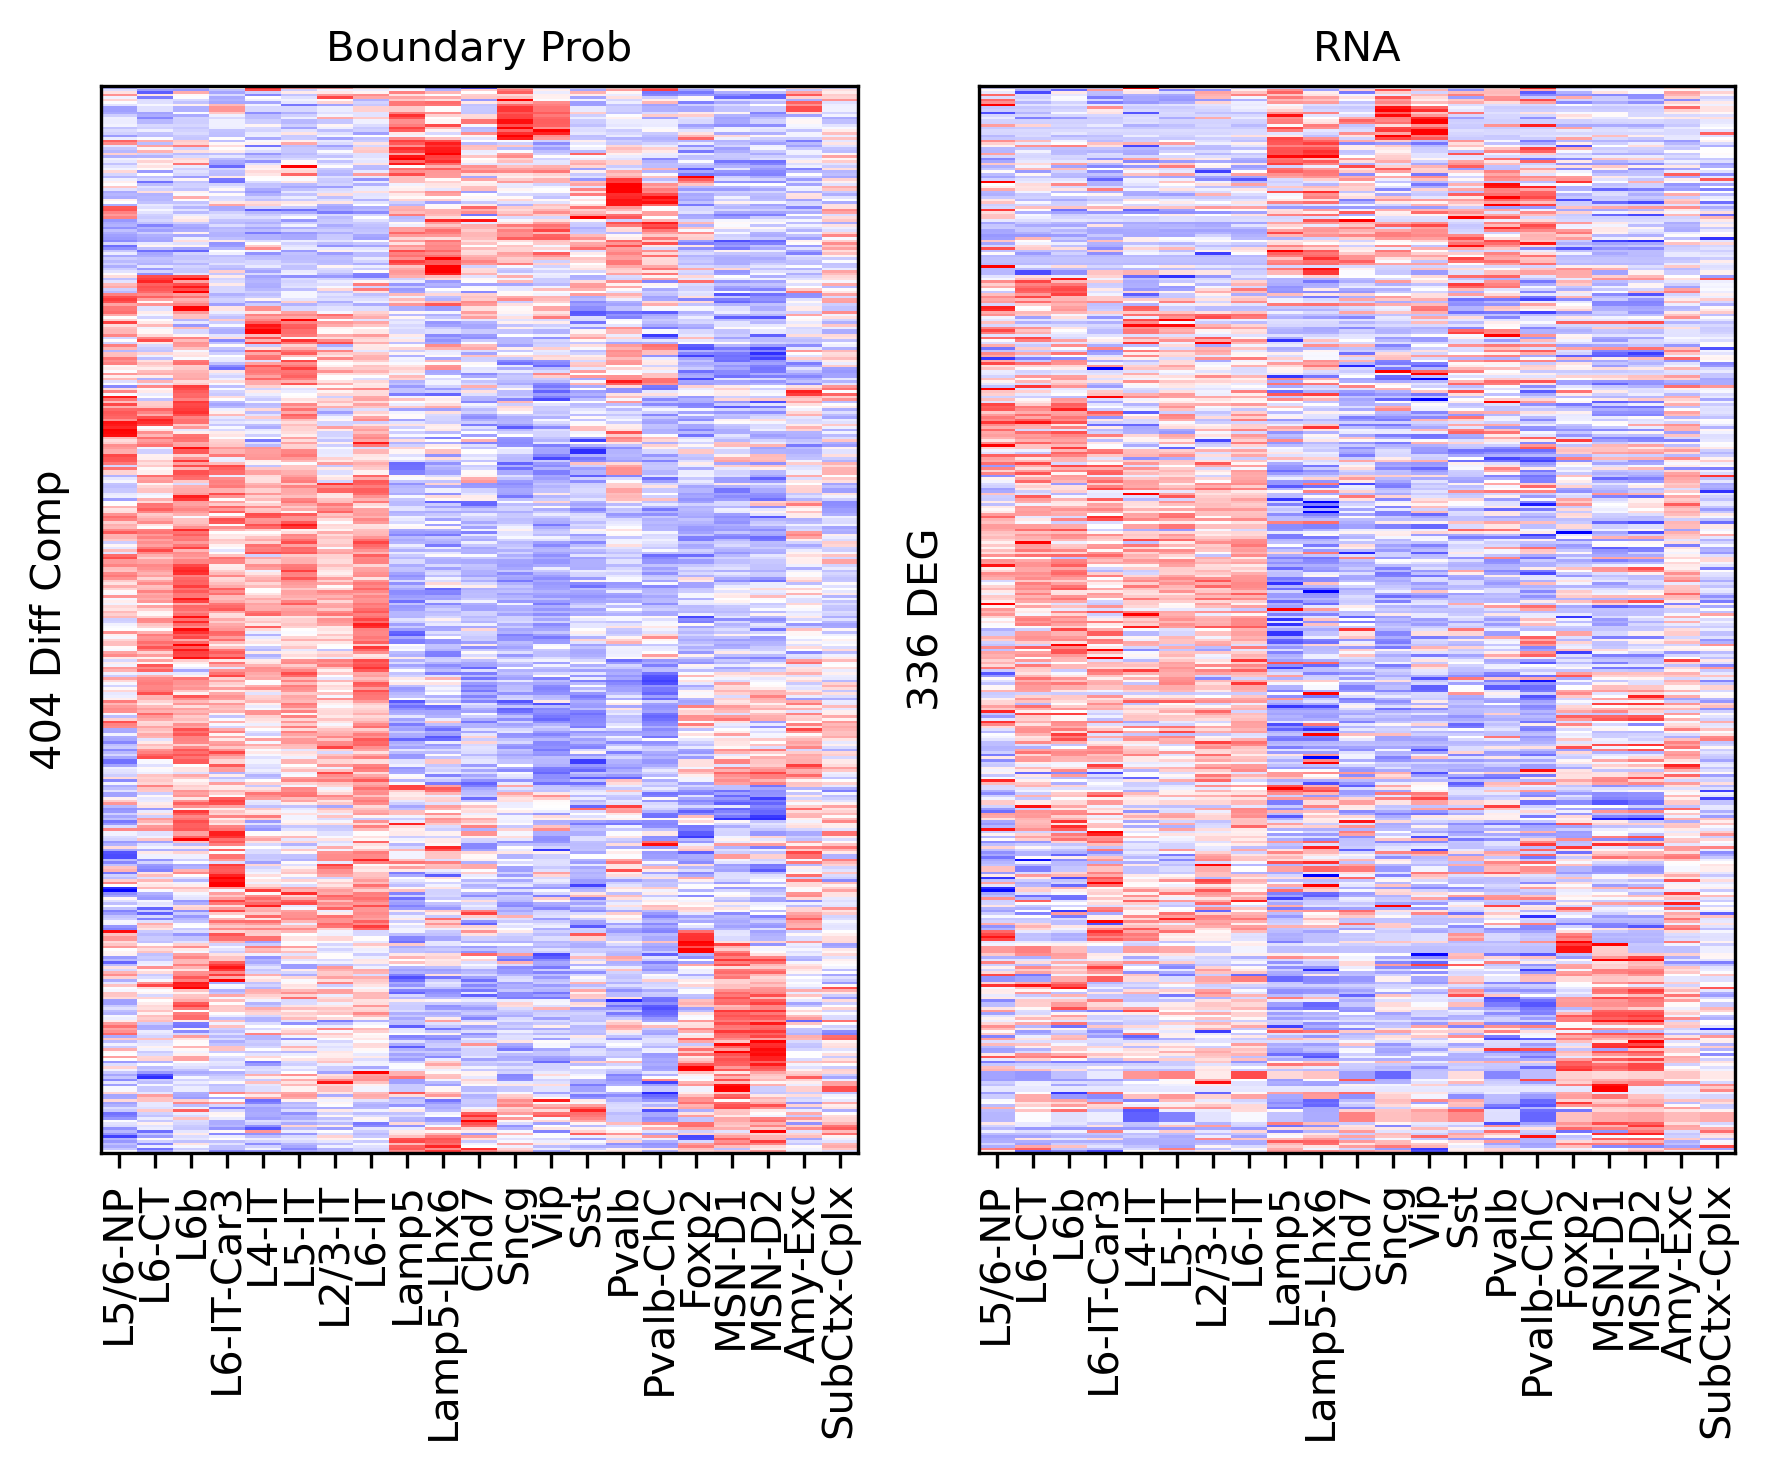

In [71]:
fig, axes = plt.subplots(1, 2, sharey='all', figsize=(6,5), dpi=300)

ax = axes[0]
ax.imshow(tmp3c[np.ix_(rorder, corder)], cmap='bwr', aspect='auto', vmin=-3, vmax=3, interpolation='none')
ax.set_title('Boundary Prob', fontsize=10)
# sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks(np.arange(len(leg)))
ax.set_xticklabels(legname[corder], rotation=90)
ax.set_yticks([])
ax.set_ylabel(f'{np.unique(data["bin_id"]).shape[0]} Diff Comp')

ax = axes[1]
ax.imshow(tmprna[np.ix_(rorder, corder)], cmap='bwr', aspect='auto', vmin=-3, vmax=3, interpolation='none')
ax.set_title('RNA', fontsize=10)
# sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks(np.arange(len(leg)))
ax.set_xticklabels(legname[corder], rotation=90)
ax.set_ylabel(f'{np.unique(data["gene_id"]).shape[0]} DEG')

plt.tight_layout()
# plt.savefig(f'majortype_{group_name}_diffbound_3C_RNA_degbody.pdf', transparent=True)


In [72]:
corr_all.append(data['corr'].values)


In [73]:
np.save(f'{outdir}corr_diffbound_rna.npy', corr_all)


In [74]:
corr_all = np.load(f'{outdir}corr_diffbound_rna.npy', allow_pickle=True)[[0,2,1,3]]


Text(0, 0.5, 'PCC with Comp Score')

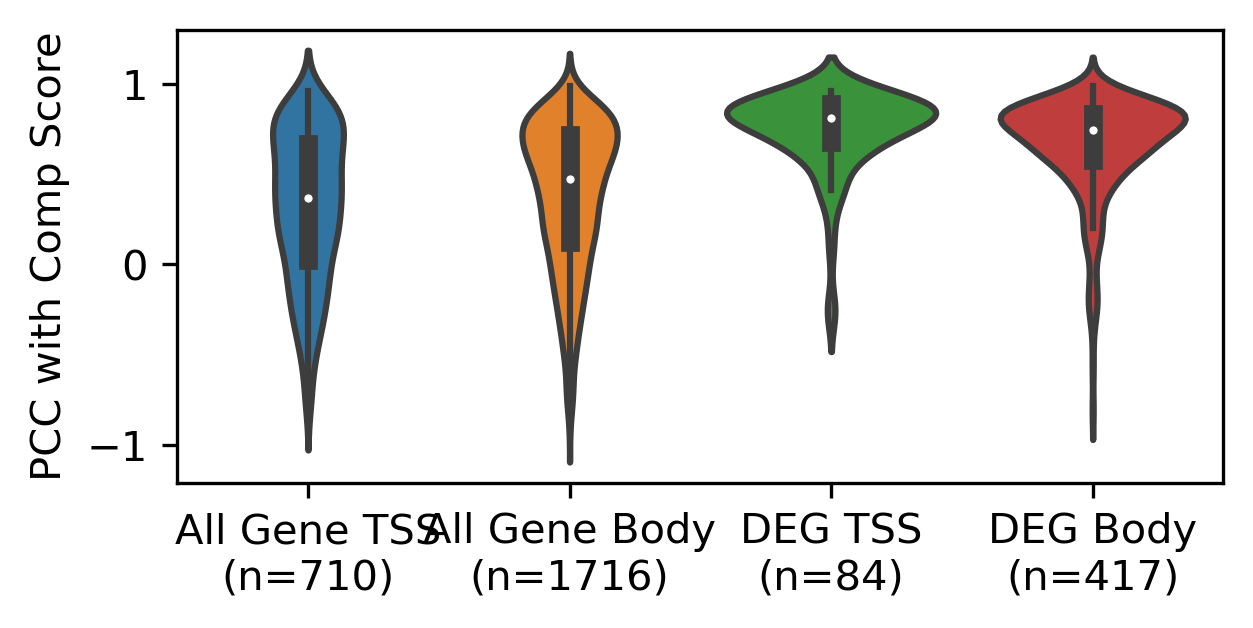

In [75]:
xleg = [f'{xx}\n(n={yy.shape[0]})' for xx,yy in zip(['All Gene TSS', 'All Gene Body', 'DEG TSS', 'DEG Body'], corr_all)]
fig, ax = plt.subplots(figsize=(4.5,2), dpi=300)
sns.violinplot(corr_all, ax=ax)
ax.set_xticklabels(xleg)
ax.set_ylabel('PCC with Comp Score')
# plt.tight_layout()
# plt.savefig(f'majortype_{group_name}_diffbound_rnacorr.pdf', transparent=True)


In [76]:
[[xx.shape, np.median(xx)] for xx in corr_all]

[[(710,), 0.36908752998291405],
 [(1716,), 0.47118865132083876],
 [(84,), 0.8121020961570051],
 [(417,), 0.7439593052340755]]